이번 포스트에서는 Reuter News Dataset을 사용하여 46개의 토픽으로 분류하는 신경망을 만들어 본다. 클래스가 많은 다중 분류 **multiclass classification**의 예시이다.

* 더 정확히 하자면 단일 레이블 다중 분류 **single-label, multiclass classification** 문제이다.
* 각 데이터 포인트가 여러개 범주에 속할 수 있다면 다중 레이블 다중 분류 **multi-label, multiclass classification** 문제가 된다.

### 로이터 데이터셋

1986년에 로이터가 공개한 이 데이터셋은 텍스트 분류를 위해 널리 사용된다. 46개의 토픽이 있으며 어떤 토픽은 다른 것에 비해 데이터가 많다. (불균형한 데이터). 각 토픽은 훈련 세트에 최소한 10개의 샘플을 가지고 있다.

##### 데이터셋 로드하기

In [1]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words = 10000)

/home/jhhur/anaconda3/envs/TIL2/lib/python3.8/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/jhhur/anaconda3/envs/TIL2/lib/python3.8/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


이전 포스트인 IMDB 이진 분류 문제처럼 `num_words = 10000`를 사용하여  가장 자주 등장하는 단어 1만개로 제한한다.

이 데이터 셋에는 8982개의 훈련 샘플과 2246개의 테스트 샘플이 있다.

```python
>>> len(train_data)
8982
>>> len(test_data)
2246
```

또한 각 샘플은 정수 리스트이다. (단어 인덱스)

```python
>>> train_data[10]
[1, 245, 273, ... , 17, 12]
```

샘플에 연결된 레이블은 토픽의 인덱스로 0과 45 사이의 정수이다.
```python
>>> train_label[10]
3
```

##### 로이터 데이터셋을 텍스트로 디코딩하기

In [2]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") for i in train_data[0]])

decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

### 데이터 준비

##### 데이터 인코딩하기

In [3]:
import numpy as np

def vectorize_sequences(sequences, dimension = 10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

두가지 방법으로 레이블을 벡터로 바꿀 수 있다.
1. 레이블의 리스트를 정수 텐서로 변환하기
2. One-hot encoding 사용하기

원핫 인코딩이 범주형 데이터에 널리 사용되기 때문에 **범주형 인코딩 (categorical encoding)**이라고 불린다.

In [4]:
def to_one_hot(labels, dimension = 46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

또는 Keras에 내장되어 있는 함수를 사용하여도 된다.

```python
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)
```

### 모델 구성

IMDB 이진 분류 문제와 다르게 새로운 *제약*이 추가되었다. 출력 클래스의 개수가 2개에서 46개로 늘어났다. 출력 공간의 차원이 훨씬 커졌다는 뜻이다.

Dense 층을 쌓으면 각 층은 이전 층의 출력에서 제공한 정보만 사용할 수 있다. 한 층이 분류 문제에 필요한 일부 정보를 누락하면 그 다음 층에서 이를 복원할 방법이 없다. 각 층은 잠재적으로 **정보의 병목(information bottleneck)**이 될 수 있다. IMDB에서 16차원을 가진 중간 층을 사용하였지만, 16차원은 46개의 클래스를 구분하기에 너무 제약이 많다.

이번 예제에서는 더 규모가 큰 층인 64개의 히든 유닛을 사용할 것이다.

##### 모델 정의하기

In [5]:
from keras import models, layers

model = models.Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape = (10000,)))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(46, activation = 'softmax'))

이 구조에서 주목해야 할 점이 2가지 있다.

1. 마지막 Dense 층의 크기가 46이다. 각 입력 샘플에 대해서 46차원의 벡터를 출력한다는 뜻. 각 원소는 각기 다른 출력 클래스이다.
2. 마지막 층에 `softmax` 활성화 함수가 사용되었다. 각 입력 샘플마다 46개의 출력 클래스에 대한 확률 분포를 출력한다.

이런 문제에 사용할 최선의 손실 함수는 `categorical_crossentropy`이다.
* 이 함수는 두 확률 분포 사이의 거리를 측정
* 네트워크가 출력한 확률 분포와 진짜 레이블의 분포 사이의 거리 측정
* 두 분포 사이의 거리를 최소화 하면 진짜 레이블에 가까운 출력이 가능

##### 모델 컴파일

In [6]:
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

### 훈련 검증

##### 검증 세트 준비하기

In [7]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

##### 모델 훈련하기

In [8]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs = 20,
                    batch_size = 512,
                    validation_data = (x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 20ms/step - loss: 3.0384 - accuracy: 0.4053 - val_loss: 1.6609 - val_accuracy: 0.6290
Epoch 2/20
16/16 [==============================] - 0s 7ms/step - loss: 1.4707 - accuracy: 0.6921 - val_loss: 1.3102 - val_accuracy: 0.6960
Epoch 3/20
16/16 [==============================] - 0s 7ms/step - loss: 1.0599 - accuracy: 0.7591 - val_loss: 1.1355 - val_accuracy: 0.7500
Epoch 4/20
16/16 [==============================] - 0s 7ms/step - loss: 0.8540 - accuracy: 0.8193 - val_loss: 1.0386 - val_accuracy: 0.7730
Epoch 5/20
16/16 [==============================] - 0s 7ms/step - loss: 0.6598 - accuracy: 0.8616 - val_loss: 0.9723 - val_accuracy: 0.7930
Epoch 6/20
16/16 [==============================] - 0s 7ms/step - loss: 0.5328 - accuracy: 0.8935 - val_loss: 0.9313 - val_accuracy: 0.8060
Epoch 7/20
16/16 [==============================] - 0s 7ms/step - loss: 0.4217 - accuracy: 0.9198 - val_loss: 0.9062 - val_accuracy: 0.8100
Epoch 8/20
16/16 [=

##### 훈련과 검증 손실 그리기

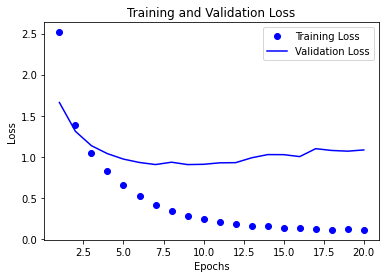

In [9]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

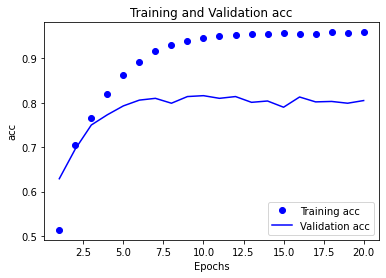

In [10]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label = "Training acc")
plt.plot(epochs, val_acc, 'b', label = "Validation acc")
plt.title("Training and Validation acc")
plt.xlabel("Epochs")
plt.ylabel("acc")
plt.legend()

plt.show()

##### 처음부터 다시 훈련하기

In [11]:
model = models.Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape = (10000,)))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(46, activation = 'softmax'))

model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs = 9,
          batch_size = 512,
          validation_data = (x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 0s 13ms/step - loss: 3.1110 - accuracy: 0.3356 - val_loss: 1.7266 - val_accuracy: 0.6450
Epoch 2/9
16/16 [==============================] - 0s 7ms/step - loss: 1.4886 - accuracy: 0.6950 - val_loss: 1.2810 - val_accuracy: 0.7250
Epoch 3/9
16/16 [==============================] - 0s 7ms/step - loss: 1.0660 - accuracy: 0.7672 - val_loss: 1.1008 - val_accuracy: 0.7550
Epoch 4/9
16/16 [==============================] - 0s 8ms/step - loss: 0.8239 - accuracy: 0.8179 - val_loss: 1.0151 - val_accuracy: 0.7840
Epoch 5/9
16/16 [==============================] - 0s 8ms/step - loss: 0.6622 - accuracy: 0.8579 - val_loss: 0.9904 - val_accuracy: 0.7920
Epoch 6/9
16/16 [==============================] - 0s 7ms/step - loss: 0.5245 - accuracy: 0.8880 - val_loss: 0.9113 - val_accuracy: 0.8050
Epoch 7/9
16/16 [==============================] - 0s 8ms/step - loss: 0.4106 - accuracy: 0.9142 - val_loss: 0.9102 - val_accuracy: 0.8050
Epoch 8/9
16/16 [=========

In [12]:
results

[1.0288153886795044, 0.7724844217300415]

대략 78%의 정확도를 달성했다. 균형 잡힌 이진 분류 문제에서 완전히 무작위로 분류하면 대략 50%의 정확도를 달성한다. 이 문제는 불균형한 데이터셋을 사용하므로 무작위로 분류하면 18% 정도를 달성한다. 78%는 매우 좋은 결과인다.

### 새로운 데이터로 예측하기

In [13]:
predictions = model.predict(x_test)

predictions의 각 항목은 길이가 46인 벡터

```python
>>> predictions[0].shape
(46, )
```

이 벡터 원소의 합은 1
```python
>>> np.sum(predictions[0])
1.0
```

가장 큰 값이 예측 클래스가 된다. 즉, 가장 확률이 높은 클래스이다.
```python
>>> np.argmax(predictions[0])
3
```

### 충분히 큰 중간 층을 두어야 하는 이유

앞서 언급한 것처럼 마지막 출력이 46차원이기 때문에 중간 층의 히든 유닛이 46개보다 많이 적어서는 안된다. 46차원보다 훨씬 작은 중간층 (예를 들어 4차원)을 두면 정보의 병목이 어떻게 나오는지 알아보자

In [14]:
model = models.Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape = (10000,)))
model.add(layers.Dense(4, activation = 'relu'))
model.add(layers.Dense(46, activation = 'softmax'))

model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs = 20,
          batch_size = 128,
          validation_data = (x_val, y_val))


Epoch 1/20
63/63 [==============================] - 0s 4ms/step - loss: 3.2930 - accuracy: 0.2043 - val_loss: 2.5288 - val_accuracy: 0.2500
Epoch 2/20
63/63 [==============================] - 0s 3ms/step - loss: 2.3491 - accuracy: 0.2518 - val_loss: 1.9479 - val_accuracy: 0.5600
Epoch 3/20
63/63 [==============================] - 0s 3ms/step - loss: 1.8365 - accuracy: 0.5472 - val_loss: 1.7008 - val_accuracy: 0.5680
Epoch 4/20
63/63 [==============================] - 0s 3ms/step - loss: 1.5844 - accuracy: 0.5753 - val_loss: 1.6040 - val_accuracy: 0.5630
Epoch 5/20
63/63 [==============================] - 0s 3ms/step - loss: 1.4203 - accuracy: 0.5838 - val_loss: 1.5834 - val_accuracy: 0.5720
Epoch 6/20
63/63 [==============================] - 0s 3ms/step - loss: 1.3521 - accuracy: 0.5865 - val_loss: 1.5644 - val_accuracy: 0.5790
Epoch 7/20
63/63 [==============================] - 0s 3ms/step - loss: 1.3039 - accuracy: 0.5878 - val_loss: 1.5980 - val_accuracy: 0.5700
Epoch 8/20
63/63 [==

검증 정확도는 71%로 약 7% 정도 감소했다. 이런 손실의 원인 대부분은 많은 정보를 중간층의 저차원 표현 공간으로 압축하려고 했기 때문. 이 네트워크는 필요한 정보 대부분을 4차원 표현 안에 구겨 넣었지만 전부를 넣지는 못하였다.